## Analysis of The Driving Hamiltonian

#### Imports

In [90]:
from collections import Counter
from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy

def plot_spectrum(eigenvalues):
    """
    Plot the vertical spectrum of a Hamiltonian, showing the eigenvalues as horizontal lines 
    and indicating their degeneracy.

    Parameters:
    eigenvalues (array-like): Array of eigenvalues of the Hamiltonian.
    """
    # Count the degeneracy of each eigenvalue
    degeneracy = Counter(eigenvalues)

    # Prepare data for plotting
    unique_eigenvalues = list(degeneracy.keys())
    degeneracies = list(degeneracy.values())

    # Plot the spectrum
    plt.figure(figsize=(6, 10))
    for i, (eig, deg) in enumerate(zip(unique_eigenvalues, degeneracies)):
        plt.hlines(eig, i - 0.2 * deg, i + 0.2 * deg, colors='b', linewidth=5)
        plt.text(i, eig, f'{deg}', horizontalalignment='center', verticalalignment='bottom', fontsize=24, color='r')

    # Make the plot fancy
    plt.title('Spectrum of the Hamiltonian', fontsize=16)
    plt.ylabel('Eigenvalue', fontsize=14)
    plt.xlabel('Index (degeneracy indicated by text)', fontsize=14)
    plt.xticks(range(len(unique_eigenvalues)), ['']*len(unique_eigenvalues))  # Remove x-axis ticks
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Show the plot
    plt.show()

file_name='data/cki'
SPS=SingleParticleState(file_name=file_name)
energies=SPS.energies

#### Hyperparameters

In [106]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2



t=3
w=-3
h=3.



J and M operator and the single particle Basis

In [107]:
matrix_j,_=get_twobody_nuclearshell_model(file_name='data/j2.int')

energies=SPS.energies

diag_j=np.zeros(energies.shape[0])
diag_m=np.zeros(energies.shape[0])
label=[]
for i in range(energies.shape[0]):
    n,l,j,m,_,tz=SPS.state_encoding[i]
    label.append((j,m,tz))
    diag_j[i]=j*(j+1)
    diag_m[i]=m

Joperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Joperator.get_twobody_interaction(twobody_dict=matrix_j)
Joperator.get_external_potential(diag_j)
Joperator.get_hamiltonian()

Jdiagoperator=FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Jdiagoperator.get_external_potential(diag_j)
Jdiagoperator.get_hamiltonian()


Moperator = FermiHubbardHamiltonian(
    size_a=size_a,
    size_b=size_b,
    nparticles_a=nparticles_a,
    nparticles_b=nparticles_b,
)

Moperator.get_external_potential(diag_m)
Moperator.get_hamiltonian()


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.84it/s]
592it [00:01, 358.57it/s]


#### Case a: CKI basis

otherwise= 0.5 0.5
0.5 1.5
otherwise= 0.5 0.5
0.5 1.5
1.5 0.5
1.5 0.5
otherwise= 0.5 0.5
0.5 1.5
otherwise= 0.5 0.5
0.5 1.5
1.5 0.5
1.5 0.5
total_m= -3.885780586188048e-16
total J^2= 4.458359213500119


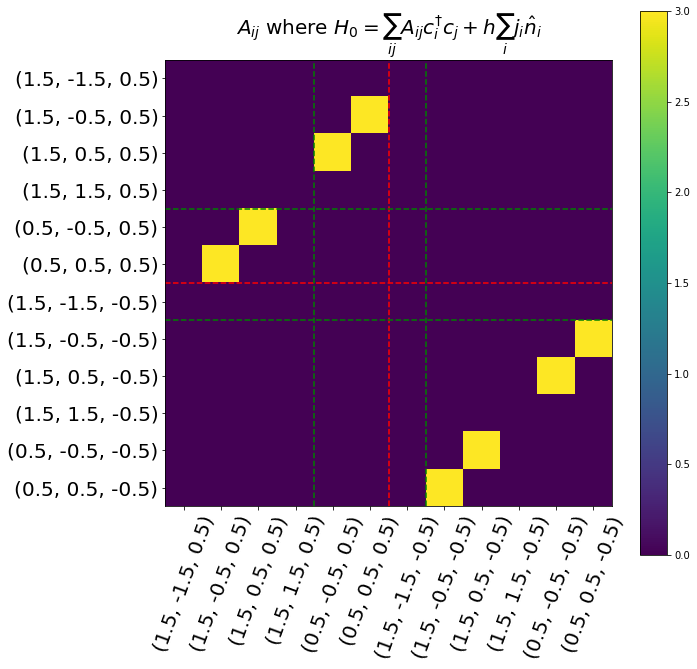

m value=   (0, 4)	-3.0
  (0, 60)	-3.0
  (1, 3)	3.0
  (1, 61)	-3.0
  (2, 62)	-3.0
  (3, 1)	-3.0
  (3, 63)	-3.0
  (4, 0)	3.0
  (4, 64)	-3.0
  (5, 7)	3.0
  (5, 11)	3.0
  (5, 65)	-3.0
  (6, 13)	3.0
  (6, 66)	-3.0
  (7, 5)	-3.0
  (7, 14)	3.0
  (7, 67)	-3.0
  (8, 68)	-3.0
  (9, 12)	-3.0
  (9, 69)	-3.0
  (10, 70)	-3.0
  (11, 5)	-3.0
  (11, 14)	3.0
  (11, 71)	-3.0
  (12, 9)	3.0
  :	:
  (217, 112)	-3.0
  (217, 172)	-3.0
  (217, 215)	-3.0
  (217, 224)	3.0
  (218, 113)	-3.0
  (218, 173)	-3.0
  (219, 114)	-3.0
  (219, 174)	-3.0
  (219, 222)	-3.0
  (220, 115)	-3.0
  (220, 175)	-3.0
  (221, 116)	-3.0
  (221, 176)	-3.0
  (221, 215)	-3.0
  (221, 224)	3.0
  (222, 117)	-3.0
  (222, 177)	-3.0
  (222, 219)	3.0
  (223, 118)	-3.0
  (223, 178)	-3.0
  (223, 216)	-3.0
  (224, 119)	-3.0
  (224, 179)	-3.0
  (224, 217)	-3.0
  (224, 221)	-3.0


In [129]:
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))

#cki
j_values=[1/2,3/2]




mj_list=[]
for j in j_values:
    m_values=-2*j+2*np.arange(0,int(2*j)+1)
    
    m_values=m_values[m_values>0.]
    for m in m_values:
        mj_list.append((m/2,j,1))

for tzi in [-1/2,1/2]:
    
    for f,tupi in enumerate(mj_list):
        mi,ji,ni=tupi
        #mj,jj,nj=mj_list[(f+1)% len(mj_list)]
        for tupj in mj_list:
            mj,jj,nj=tupj
            if mi!=mj:
                print(mi,mj)
                continue
            if ji==jj:
                continue
            print('otherwise=',mi,mj)
            #if ni==nj:
            i=SPS.get_index((ni,0,ji,mi,1/2,tzi))
            k=SPS.get_index((ni,0,ji,-1*mi,1/2,tzi))
            j=SPS.get_index((nj,0,jj,mj,1/2,tzi))
            l=SPS.get_index((nj,0,jj,-1*mj,1/2,tzi))
            kinetic_term[(i,j)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,i)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,i]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(i,l)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,l]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(l,i)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,i]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,j)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,j]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(j,k)]=t/2-w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[j,k]=t/2-w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(k,l)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[k,l]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
            
            kinetic_term[(l,k)]=t/2+w/2 #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[l,k]=t/2+w/2#np.abs(mi-mj)#+np.abs(ji-jj)
        


                
external_field=np.zeros(size_a+size_b)
rand=np.random.uniform(0,1,3)
rand_dict={1/2:rand[0],-1/2:rand[1]}
for i in range(size_a+size_b):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    j=SPS.get_index((ni,li,ji,-mi,ti,tzi))
    external_field[i]=h*(ji)

    
    #external_field[i] = SPS.energies[i]


InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=8

es,psis=InitialHamiltonian.get_spectrum(n_states=nlevels)
einitial=es[0]
psi_initial=psis[:,0]
print('total_m=',SPS.compute_m_exp_value(psi=psi_initial,basis=InitialHamiltonian.basis))
print('total J^2=',psi_initial.transpose().conjugate() @ Joperator.hamiltonian @ psi_initial)
plt.figure(figsize=(10,10))

plt.title(r'$A_{ij}$ where $H_0=\sum_{ij}A_{ij} c^{\dagger}_i c_j + h \sum_i j_i \hat{n}_i$',fontsize=20)
plt.imshow(adj_matrix)
plt.xticks(np.arange(diag_m.shape[0]),label,rotation=70)
plt.yticks(np.arange(diag_m.shape[0]),label)
plt.colorbar()
plt.savefig('images/fig4')
plt.tick_params(which='major',labelsize=20)
plt.axhline(y=energies.shape[0]//2-0.5,color='red',linestyle='--')
plt.axvline(x=energies.shape[0]//2-0.5,color='red',linestyle='--')

plt.axhline(y=energies.shape[0]-5.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-5.5,color='green',linestyle='--')


plt.axhline(y=energies.shape[0]-8.5,color='green',linestyle='--')
plt.axvline(x=energies.shape[0]-8.5,color='green',linestyle='--')

plt.show()

#print(InitialHamiltonian.hamiltonian)
print('m value=',Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian)

#### Single Particle Hamiltonian

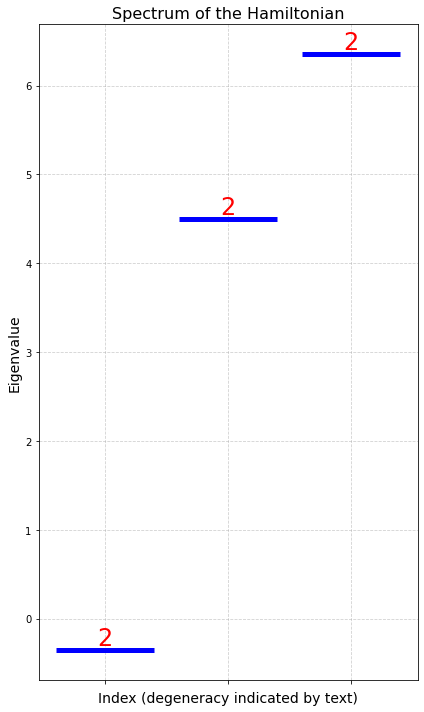

component= (1.5, -1.5, 0.5) value= 1.0 

component= (1.5, -0.5, 0.5) value= 0.0 

component= (1.5, 0.5, 0.5) value= 0.0 

component= (1.5, 1.5, 0.5) value= 0.0 

component= (0.5, -0.5, 0.5) value= 0.0 

component= (0.5, 0.5, 0.5) value= 0.0 



In [130]:
single_particle_hamiltonian=adj_matrix[:size_a,:size_a]+external_field[:size_a,None]*np.eye(size_a)


eigenvalues,states=np.linalg.eigh(single_particle_hamiltonian)

plot_spectrum(eigenvalues)

nstate=2
for i in range(len(label[:size_a])):
    print('component=',label[i],'value=',states[i,nstate],'\n')


### $n_i$ expectation value

In [116]:
n_expectation=np.zeros((nlevels,size_a+size_b))

for j in range(nlevels):
    for i in range(size_a+size_b):
        
        op=InitialHamiltonian.adag_a_matrix(i=i,j=i)
        n_expectation[j,i]=( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))


m_expectation=[]
j_expectation=[]
jdiag_expectation=[]
for j in range(nlevels):
    op=Moperator.hamiltonian
    op_j=Joperator.hamiltonian
    op_jdiag=Jdiagoperator.hamiltonian
    m_expectation.append( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))
    j_expectation.append((psis[:,j].conjugate().transpose() @ op_j @ psis[:,j]))
    jdiag_expectation.append((psis[:,j].conjugate().transpose() @ op_j @ psis[:,j]))

        
        
        





Plot

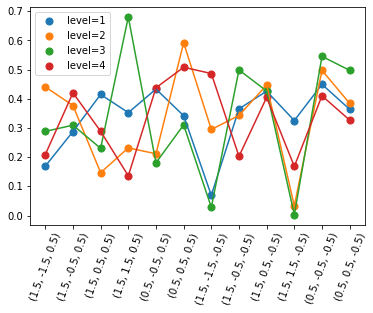

[-1.41640786  3.4376941   3.4376941   3.4376941   3.4376941   3.4376941
  5.29179607  5.29179607]
[-0.0032235779859028325, 0.6649641517141092, -0.6354654160051527, 0.5153645113602751, -0.5585953396871222, 0.46568533112989347, 0.002086649466166145, 0.1278549625667652]
[6.577877310135358, 8.184300632963588, 8.188501233306923, 8.238654346913608, 8.969072681035101, 7.812693405014884, 9.157770024150258, 6.731553253524671]
32.00000000000001


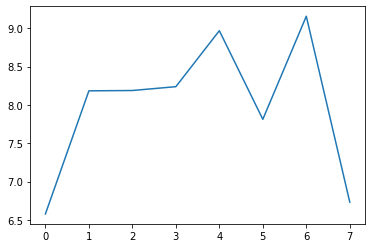

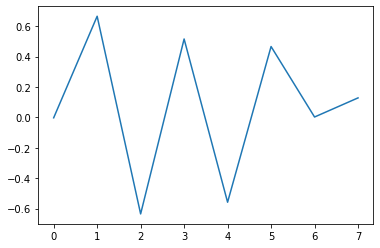

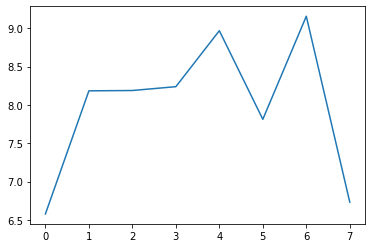

In [131]:
for i in range(1,5):
    plt.plot(n_expectation[i])
    plt.scatter(np.arange(energies.shape[0]),n_expectation[i],s=50,label=f'level={i}')
    plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
    
plt.legend()
plt.show()

print(es)
print(m_expectation)
print(j_expectation)
print(np.sum(n_expectation))

plt.plot(j_expectation)
plt.show()

plt.plot(m_expectation)
plt.show()

plt.plot(jdiag_expectation)
plt.show()



#### Correlation function

In [132]:
correlation_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    for j in range(size_a):
        op=InitialHamiltonian.adag_a_matrix(i=i,j=j)
        print(op,i,j,'\n')
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))
        
for i in range(size_a,size_a+size_b):
    for j in range(size_a,size_a+size_b):
        op=InitialHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))


  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  (25, 25)	1.0
  (26, 26)	1.0
  (27, 27)	1.0
  (28, 28)	1.0
  (29, 29)	1.0
  (30, 30)	1.0
  (31, 31)	1.0
  (32, 32)	1.0
  (33, 33)	1.0
  (34, 34)	1.0
  (35, 35)	1.0
  (36, 36)	1.0
  (37, 37)	1.0
  (38, 38)	1.0
  (39, 39)	1.0
  (40, 40)	1.0
  (41, 41)	1.0
  (42, 42)	1.0
  (43, 43)	1.0
  (44, 44)	1.0
  (45, 45)	1.0
  (46, 46)	1.0
  (47, 47)	1.0
  (48, 48)	1.0
  (49, 49)	1.0
  (50, 50)	1.0
  (51, 51)	1.0
  (52, 52)	1.0
  (53, 53)	1.0
  (54, 54)	1.0
  (55, 55)	1.0
  (56, 56)	1.0
  (57, 57)	1.0
  (58, 58)	1.0
  (59, 59)	1.0
  (60, 60)	1.0
  (61, 61)	1.0
  (62, 62)	1.0
  (63, 63)	1.0
  (64, 64)	1.0
  (65, 65)	1.0
  (66, 66)	1.0
  (67, 67)	1.0


Plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '(1.5, -1.5, 0.5)'),
  Text(1, 0, '(1.5, -0.5, 0.5)'),
  Text(2, 0, '(1.5, 0.5, 0.5)'),
  Text(3, 0, '(1.5, 1.5, 0.5)'),
  Text(4, 0, '(0.5, -0.5, 0.5)'),
  Text(5, 0, '(0.5, 0.5, 0.5)'),
  Text(6, 0, '(1.5, -1.5, -0.5)'),
  Text(7, 0, '(1.5, -0.5, -0.5)'),
  Text(8, 0, '(1.5, 0.5, -0.5)'),
  Text(9, 0, '(1.5, 1.5, -0.5)'),
  Text(10, 0, '(0.5, -0.5, -0.5)'),
  Text(11, 0, '(0.5, 0.5, -0.5)')])

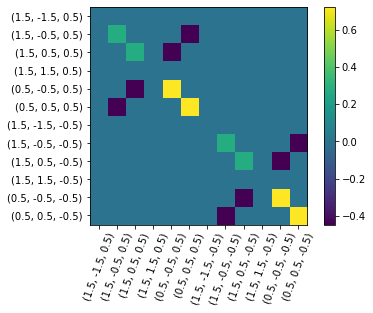

In [133]:
plt.imshow(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)
plt.xticks()

#### Target Hamiltonian

In [84]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

iso_dict={-0.5:'n',0.5:'p'}
values=np.asarray(list(twobody_matrix.values()))
print(np.average(np.abs(values)))
for key in twobody_matrix.keys():
    i,j,k,l=key
    (n,_,ja,ma,t,tza)=SPS.state_encoding[i]
    (n,_,jb,mb,t,tzb)=SPS.state_encoding[j]
    (n,_,jc,mc,t,tzc)=SPS.state_encoding[k]
    (n,_,jd,md,t,tzd)=SPS.state_encoding[l]

    print(ja,ma,iso_dict[tza]+'+'+iso_dict[tzb],jb,mb,'-->',jc,mc,iso_dict[tzc]+'+'+iso_dict[tzd],jd,md)
    print('cross section=',twobody_matrix[key],'\n')
    
    

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.84it/s]


1.4069726715197104
1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -1.5 p+p 1.5 -0.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -0.5 p+p 1.5 -1.5
cross section= 0.6490000000000002 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 1.5 -0.5
cross section= 0.6490000000000002 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -0.5 p+p 1.5 -1.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 -0.5 --> 1.5 -1.5 p+p 0.5 -0.5
cross section= 2.2055000000000007 

1.5 -1.5 p+p 1.5 -0.5 --> 0.5 -0.5 p+p 1.5 -1.5
cross section= -2.2055000000000007 

1.5 -0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 0.5 -0.5
cross section= -2.2055000000000007 

1.5 -0.5 p+p 1.5 -1.5 --> 0.5 -0.5 p+p 1.5 -1.5
cross section= 2.2055000000000007 

1.5 -1.5 p+p 1.5 0.5 --> 1.5 -1.5 p+p 1.5 0.5
cross section= -0.6490000000000002 

1.5 -1.5 p+p 1.5 0.5 --> 1.5 0.5 p+p 1.5 -1.5
cross section= 0.6490000000000002 

1.5 0.5 p+p 1.5 -1.5 --> 1.5 -1.5 p+p 1.5 0.5
cross section= 0.6490000000000002 

1.5 0.5 p+p 1.5 -1.5 --> 1.5 0.5 p+p 1.5 -1.5
cross sectio

In [122]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()

nlevles=3

egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)

print(egs)
psi0=psis[:,0]


print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=TargetHamiltonian.basis))










j2=psi0.transpose().dot(Joperator.hamiltonian.dot(psi0))
jvalue=0.5 * ( np.sqrt(4.0 * j2 + 1) - 1 )

print('total_J=',jvalue)
print('m value=',Moperator.hamiltonian @ TargetHamiltonian.hamiltonian- TargetHamiltonian.hamiltonian @ Moperator.hamiltonian)

size= 12 6


0it [00:00, ?it/s]

1424it [00:04, 340.60it/s]


[-30.29539461 -26.88369692 -26.88369692 -26.88369692 -26.88369692
 -26.88369692 -19.0041005  -19.0041005  -19.0041005  -19.0041005 ]
total_m= 0.0
total_J= 6.106226635438361e-15
m value= 


particle distribution

In [123]:
n_expectation_nsmodel=np.zeros((nlevels,size_a+size_b))

for j in range(nlevels):
    for i in range(size_a+size_b):
        
        op=InitialHamiltonian.adag_a_matrix(i=i,j=i)
        n_expectation_nsmodel[j,i]=( (psis[:,j].conjugate().transpose() @ op @ psis[:,j]))



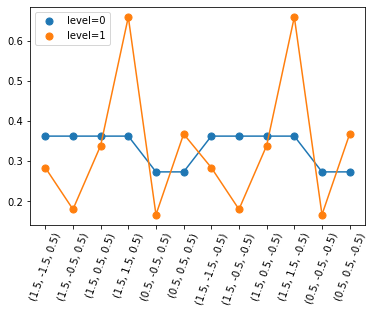

40.00000000000003


In [124]:
for i in range(2):
    plt.plot(n_expectation_nsmodel[i])
    plt.scatter(np.arange(energies.shape[0]),n_expectation_nsmodel[i],s=50,label=f'level={i}')
    plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.legend()
plt.show()

print(np.sum(n_expectation_nsmodel))

#### Correlation Matrix

In [125]:
correlation_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    for j in range(size_a):
        op=TargetHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))
        
for i in range(size_a,size_a+size_b):
    for j in range(size_a,size_a+size_b):
        op=TargetHamiltonian.adag_a_matrix(i=i,j=j)
        correlation_matrix[j,i]=( (psis[:,0].conjugate().transpose() @ op @ psis[:,0]))

Plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '(1.5, -1.5, 0.5)'),
  Text(1, 0, '(1.5, -0.5, 0.5)'),
  Text(2, 0, '(1.5, 0.5, 0.5)'),
  Text(3, 0, '(1.5, 1.5, 0.5)'),
  Text(4, 0, '(0.5, -0.5, 0.5)'),
  Text(5, 0, '(0.5, 0.5, 0.5)'),
  Text(6, 0, '(1.5, -1.5, -0.5)'),
  Text(7, 0, '(1.5, -0.5, -0.5)'),
  Text(8, 0, '(1.5, 0.5, -0.5)'),
  Text(9, 0, '(1.5, 1.5, -0.5)'),
  Text(10, 0, '(0.5, -0.5, -0.5)'),
  Text(11, 0, '(0.5, 0.5, -0.5)')])

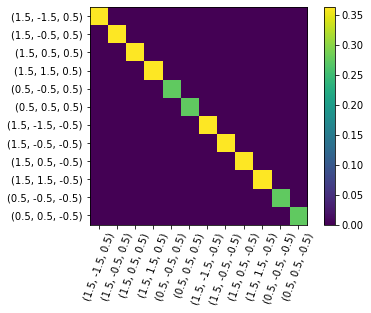

In [126]:
plt.imshow(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(energies.shape[0]),label,rotation=70)
plt.yticks(np.arange(energies.shape[0]),label)
plt.xticks()

#### Annealing

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


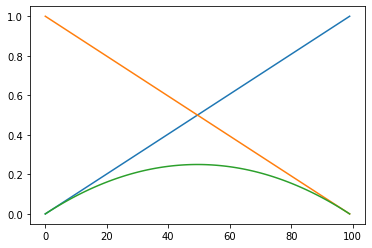

In [134]:
ngrid=100
nlevels=10
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))
psi_spectrum = np.zeros((nlevels, InitialHamiltonian.basis.shape[0]))
n_evolution=np.zeros((nlevels,ngrid, InitialHamiltonian.basis.shape[-1]))
j_values=np.zeros_like(spectrum)
m_values = np.zeros_like(spectrum)
comm=np.zeros_like(spectrum)
plt.plot(lambd)
plt.plot(1-lambd)
plt.plot(lambd*(1-lambd))

for i in trange(ngrid):

    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian#+lambd[i]*(1-lambd[i])*IntermediateHamiltonian.hamiltonian   

    values,psis=eigsh(ham,k=nlevels,which='SA')
    for a in range(psis.shape[-1]):    
        j_values[a,i]=psis[:,a].conjugate().transpose() @ Joperator.hamiltonian @ psis[:,a]
        m_values[a, i] = SPS.compute_m_exp_value(psi=psis[:,a],basis=InitialHamiltonian.basis)
        comm[a,i]=(psis[:,a].conjugate().transpose() @ Moperator.hamiltonian @ InitialHamiltonian.hamiltonian- InitialHamiltonian.hamiltonian @ Moperator.hamiltonian @ psis[:,a])[0]
        for r in range(size_a+size_b):
    
            op=InitialHamiltonian.adag_a_matrix(i=r,j=r)
            n_evolution[a,i,r]= (psis[:,a].conjugate().transpose() @ op @ psis[:,a])


    spectrum[:,i]=values
    psi_spectrum=psis

Plots

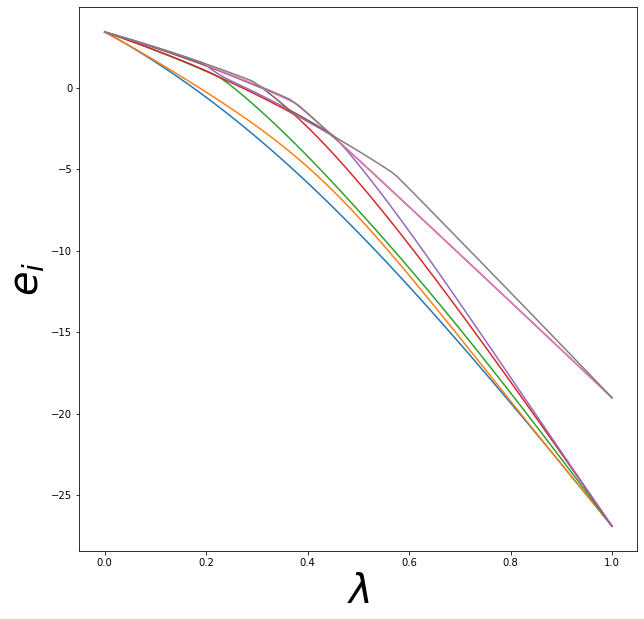

In [135]:
plt.figure(figsize=(10,10))
for i in range(1,9):
    plt.plot(lambd,spectrum[i])
# plt.xlim([0.9,1])
#plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)

plt.show()

#### n particle number

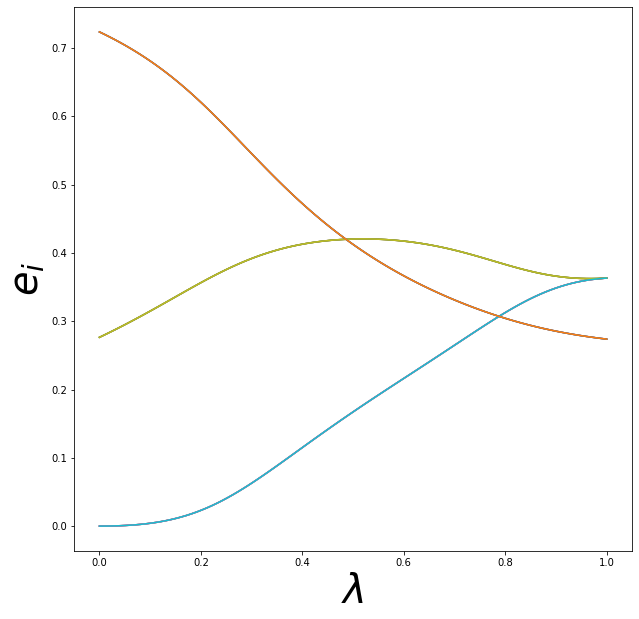

In [48]:
plt.figure(figsize=(10,10))
for r in range(energies.shape[0]):
    for i in range(1):
        plt.plot(lambd,n_evolution[i,:,r],label=f'state={r}')
        
# plt.xlim([0.9,1])
#plt.axhline(y=egs, color="red", linewidth=3, linestyle="--")
plt.xlabel(r'$\lambda$',fontsize=40)
plt.ylabel(r'$e_i$',fontsize=40)

plt.show()